# Brain Tumor Detection Using a Convolutional Neural Network

**About the Brain MRI Images dataset:**<br>
The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous and the folder no contains 98 Brain MRI Images that are non-tumorous. You can find it [here](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection).

## Import Necessary Modules

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

c:\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Preparation & Preprocessing

In [78]:
import os
pip install tensorflow sciki cv2 imutils numpy matplotlib time
os.getcwd()

'd:\\Code_Aveangers\\Projects-2024\\srilipta-major\\Brain-Tumor-Detection'

In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain. You can read more about it here [Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

In [2]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

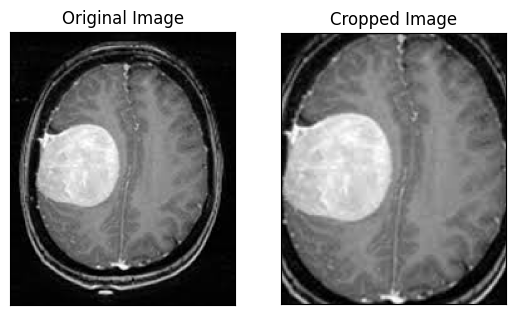

In [3]:
ex_img = cv2.imread('yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following: 
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to <i>X</i> and its label to <i>y</i>.<br>

After that, Shuffle <i>X</i> and <i>y</i>, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).<br>
Finally, Return <i>X</i> and <i>y</i>.

In [84]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size

    print(dir_list)
    
    for directory in dir_list:
        for filename in listdir(directory):
            print(filename)
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [79]:
listdir('/BTDS/augmented_data/yes/')

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/BTDS/augmented_data/yes/'

Load up the data that we augmented earlier in the Data Augmentation notebook.<br>
**Note:** the augmented data directory contains not only the new generated images but also the original images.

In [85]:
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

['augmented data/yes', 'augmented data/no']
aug_Y100_0_2052.jpg
aug_Y100_0_4855.jpg
aug_Y100_0_5724.jpg
aug_Y100_0_7447.jpg
aug_Y100_0_8282.jpg
aug_Y100_0_8493.jpg
aug_Y100_0_9772.jpg
aug_Y101_0_1228.jpg
aug_Y101_0_2073.jpg
aug_Y101_0_2175.jpg
aug_Y101_0_236.jpg
aug_Y101_0_3623.jpg
aug_Y101_0_377.jpg
aug_Y101_0_639.jpg
aug_Y102_0_2156.jpg
aug_Y102_0_3992.jpg
aug_Y102_0_4385.jpg
aug_Y102_0_5952.jpg
aug_Y102_0_616.jpg
aug_Y102_0_6866.jpg
aug_Y102_0_8273.jpg
aug_Y103_0_2659.jpg
aug_Y103_0_3047.jpg
aug_Y103_0_3473.jpg
aug_Y103_0_4223.jpg
aug_Y103_0_4870.jpg
aug_Y103_0_6859.jpg
aug_Y103_0_8711.jpg
aug_Y104_0_1465.jpg
aug_Y104_0_3957.jpg
aug_Y104_0_4099.jpg
aug_Y104_0_4787.jpg
aug_Y104_0_4923.jpg
aug_Y104_0_6672.jpg
aug_Y104_0_8522.jpg
aug_Y105_0_1041.jpg
aug_Y105_0_4376.jpg
aug_Y105_0_4612.jpg
aug_Y105_0_508.jpg
aug_Y105_0_7085.jpg
aug_Y105_0_7576.jpg
aug_Y105_0_9236.jpg
aug_Y106_0_2432.jpg
aug_Y106_0_4503.jpg
aug_Y106_0_5815.jpg
aug_Y106_0_6771.jpg
aug_Y106_0_8422.jpg
aug_Y106_0_8790.jpg
a

KeyboardInterrupt: 

As we see, we have 2065 images. Each images has a shape of **(240, 240, 3)=(image_width, image_height, number_of_channels)**

### Plot sample images:

In [7]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

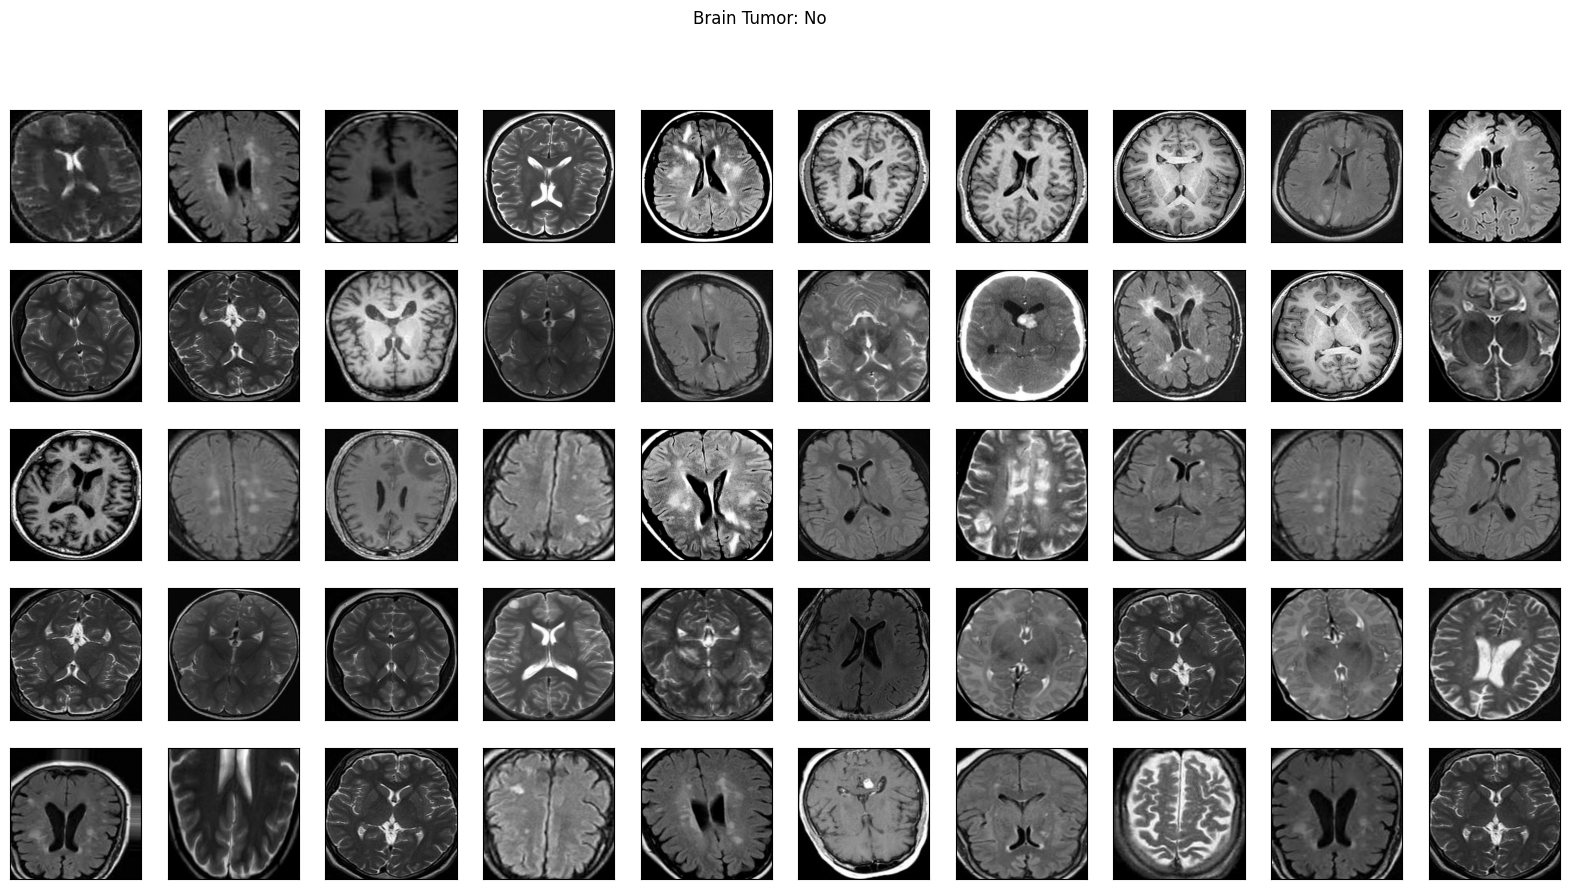

KeyboardInterrupt: 

In [8]:
plot_sample_images(X, y)

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [6]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [8]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


Some helper functions:

In [9]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [10]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Build the model

Let's build a convolutional neural network model:

<img src='convnet_architecture.jpg'>

In [11]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [12]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [13]:
model = build_model(IMG_SHAPE)

In [14]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 244, 244, 3)       0         
 g2D)                                                            
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

Compile the model:

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [33]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

## Train the model

In [35]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])
# model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
46/46 [==============================] - ETA: 0s - loss: 0.1021 - accuracy: 0.9751INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.86.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.86.model\assets


46/46 [==============================] - 27s 556ms/step - loss: 0.1021 - accuracy: 0.9751 - val_loss: 0.3706 - val_accuracy: 0.8645
Epoch 2/10
46/46 [==============================] - ETA: 0s - loss: 0.1204 - accuracy: 0.9640INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.80.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.80.model\assets


46/46 [==============================] - 28s 608ms/step - loss: 0.1204 - accuracy: 0.9640 - val_loss: 0.5640 - val_accuracy: 0.8000
Epoch 3/10
46/46 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 0.9689INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.85.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.85.model\assets


46/46 [==============================] - 22s 488ms/step - loss: 0.1078 - accuracy: 0.9689 - val_loss: 0.4432 - val_accuracy: 0.8484
Epoch 4/10
46/46 [==============================] - ETA: 0s - loss: 0.1050 - accuracy: 0.9640INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.89.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.89.model\assets


46/46 [==============================] - 22s 476ms/step - loss: 0.1050 - accuracy: 0.9640 - val_loss: 0.3392 - val_accuracy: 0.8903
Epoch 5/10
46/46 [==============================] - ETA: 0s - loss: 0.1204 - accuracy: 0.9592INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.88.model\assets


46/46 [==============================] - 21s 462ms/step - loss: 0.1204 - accuracy: 0.9592 - val_loss: 0.4045 - val_accuracy: 0.8839
Epoch 6/10
46/46 [==============================] - ETA: 0s - loss: 0.0846 - accuracy: 0.9799INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.88.model\assets


46/46 [==============================] - 21s 466ms/step - loss: 0.0846 - accuracy: 0.9799 - val_loss: 0.3718 - val_accuracy: 0.8806
Epoch 7/10
46/46 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9813INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-07-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-07-0.88.model\assets


46/46 [==============================] - 21s 461ms/step - loss: 0.0779 - accuracy: 0.9813 - val_loss: 0.3741 - val_accuracy: 0.8774
Epoch 8/10
46/46 [==============================] - ETA: 0s - loss: 0.0906 - accuracy: 0.9737INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.81.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.81.model\assets


46/46 [==============================] - 22s 479ms/step - loss: 0.0906 - accuracy: 0.9737 - val_loss: 0.6458 - val_accuracy: 0.8065
Epoch 9/10
46/46 [==============================] - ETA: 0s - loss: 0.0754 - accuracy: 0.9841INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.84.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.84.model\assets


46/46 [==============================] - 25s 555ms/step - loss: 0.0754 - accuracy: 0.9841 - val_loss: 0.4226 - val_accuracy: 0.8387
Epoch 10/10
46/46 [==============================] - ETA: 0s - loss: 0.0615 - accuracy: 0.9896INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.88.model\assets


46/46 [==============================] - 22s 482ms/step - loss: 0.0615 - accuracy: 0.9896 - val_loss: 0.3433 - val_accuracy: 0.8806
Elapsed time: 0:4:41.4


Let's train for a few more epochs:

In [36]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - ETA: 0s - loss: 0.0527 - accuracy: 0.9924INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.89.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.89.model\assets


46/46 [==============================] - 27s 580ms/step - loss: 0.0527 - accuracy: 0.9924 - val_loss: 0.3387 - val_accuracy: 0.8903
Epoch 2/3
46/46 [==============================] - ETA: 0s - loss: 0.0477 - accuracy: 0.9931INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.88.model\assets


46/46 [==============================] - 22s 489ms/step - loss: 0.0477 - accuracy: 0.9931 - val_loss: 0.4136 - val_accuracy: 0.8774
Epoch 3/3
46/46 [==============================] - ETA: 0s - loss: 0.0528 - accuracy: 0.9917INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.87.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.87.model\assets


46/46 [==============================] - 23s 495ms/step - loss: 0.0528 - accuracy: 0.9917 - val_loss: 0.3775 - val_accuracy: 0.8742
Elapsed time: 0:1:45.0


In [37]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - ETA: 0s - loss: 0.0581 - accuracy: 0.9882INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.88.model\assets


46/46 [==============================] - 27s 583ms/step - loss: 0.0581 - accuracy: 0.9882 - val_loss: 0.3624 - val_accuracy: 0.8806
Epoch 2/3
46/46 [==============================] - ETA: 0s - loss: 0.0413 - accuracy: 0.9965INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.88.model\assets


46/46 [==============================] - 24s 517ms/step - loss: 0.0413 - accuracy: 0.9965 - val_loss: 0.3813 - val_accuracy: 0.8839
Epoch 3/3
46/46 [==============================] - ETA: 0s - loss: 0.0554 - accuracy: 0.9896INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.89.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.89.model\assets


46/46 [==============================] - 26s 573ms/step - loss: 0.0554 - accuracy: 0.9896 - val_loss: 0.3634 - val_accuracy: 0.8871
Elapsed time: 0:1:39.7


In [38]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - ETA: 0s - loss: 0.0415 - accuracy: 0.9938INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.88.model\assets


46/46 [==============================] - 31s 648ms/step - loss: 0.0415 - accuracy: 0.9938 - val_loss: 0.3822 - val_accuracy: 0.8806
Epoch 2/3
46/46 [==============================] - ETA: 0s - loss: 0.0357 - accuracy: 0.9972INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.86.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.86.model\assets


46/46 [==============================] - 23s 507ms/step - loss: 0.0357 - accuracy: 0.9972 - val_loss: 0.4146 - val_accuracy: 0.8645
Epoch 3/3
46/46 [==============================] - ETA: 0s - loss: 0.0313 - accuracy: 0.9986INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.88.model\assets


46/46 [==============================] - 23s 507ms/step - loss: 0.0313 - accuracy: 0.9986 - val_loss: 0.3545 - val_accuracy: 0.8839
Elapsed time: 0:2:7.1


In [39]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
46/46 [==============================] - ETA: 0s - loss: 0.0354 - accuracy: 0.9972INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.89.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.89.model\assets


46/46 [==============================] - 34s 702ms/step - loss: 0.0354 - accuracy: 0.9972 - val_loss: 0.3599 - val_accuracy: 0.8903
Epoch 2/5
46/46 [==============================] - ETA: 0s - loss: 0.0323 - accuracy: 0.9986INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.89.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.89.model\assets


46/46 [==============================] - 25s 547ms/step - loss: 0.0323 - accuracy: 0.9986 - val_loss: 0.3481 - val_accuracy: 0.8935
Epoch 3/5
46/46 [==============================] - ETA: 0s - loss: 0.0254 - accuracy: 1.0000INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.88.model\assets


46/46 [==============================] - 26s 568ms/step - loss: 0.0254 - accuracy: 1.0000 - val_loss: 0.3650 - val_accuracy: 0.8806
Epoch 4/5
46/46 [==============================] - ETA: 0s - loss: 0.0264 - accuracy: 0.9986INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.85.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.85.model\assets


46/46 [==============================] - 27s 592ms/step - loss: 0.0264 - accuracy: 0.9986 - val_loss: 0.4851 - val_accuracy: 0.8548
Epoch 5/5
46/46 [==============================] - ETA: 0s - loss: 0.0386 - accuracy: 0.9945INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.81.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.81.model\assets


46/46 [==============================] - 25s 547ms/step - loss: 0.0386 - accuracy: 0.9945 - val_loss: 0.5795 - val_accuracy: 0.8065
Elapsed time: 0:2:53.0


In [40]:
history = model.history.history

In [41]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


## Plot Loss & Accuracy

In [46]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

**Note:** Since we trained the model using more than model.fit() function call, this made the history only contain the metric values of the epochs for the last call (which was for 5 epochs), so to plot the metric values across the whole process of trianing the model from the beginning, I had to grab the rest of the values. 

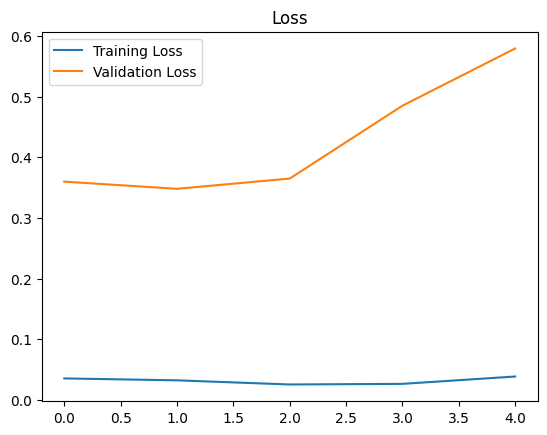

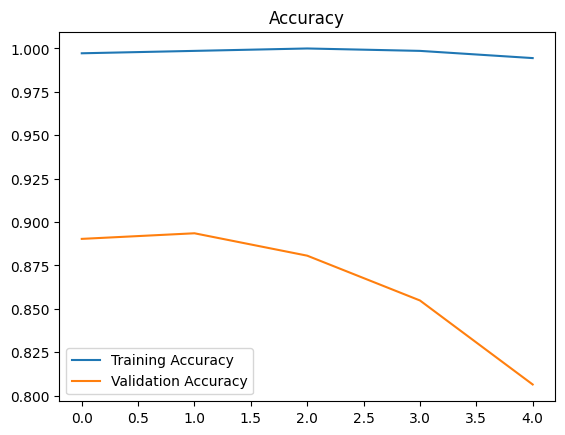

In [47]:
plot_metrics(history) 

# Results

Let's experiment with the best model (the one with the best validation accuracy):

Concretely, the model at the 23rd iteration with validation accuracy of 91%

### Load the best model

In [61]:
best_model = load_model(filepath='models/cnn-parameters-improvement-10-0.88.model')

In [62]:
best_model.metrics_names

['loss', 'accuracy']

Evaluate the best model on the testing data:

In [63]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 2s 126ms/step - loss: 0.2827 - accuracy: 0.8968


### Accuracy of the best model on the testing data:

In [64]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.2826685607433319
Test Accuracy = 0.896774172782898


### F1 score for the best model on the testing data:

In [65]:
y_test_prob = best_model.predict(X_test)

10/10 [==============================] - 1s 117ms/step


In [66]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9069767441860465


Let's also find the f1 score on the validation data:

In [67]:
y_val_prob = best_model.predict(X_val)

10/10 [==============================] - 1s 121ms/step


In [68]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.877076411960133


### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [69]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [70]:
# the whole data
data_percentage(y)

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [86]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 52.80276816608997%, number of pos examples: 763
Percentage of negative examples: 47.19723183391003%, number of neg examples: 682
Validation Data:
Number of examples: 310
Percentage of positive examples: 47.74193548387097%, number of pos examples: 148
Percentage of negative examples: 52.25806451612903%, number of neg examples: 162
Testing Data:
Number of examples: 310
Percentage of positive examples: 56.12903225806452%, number of pos examples: 174
Percentage of negative examples: 43.87096774193548%, number of neg examples: 136


As expectred, the percentage of positive examples are around 50%.

# Conclusion:

#### Now, the model detects brain tumor with:<br>
**88.7%** accuracy on the **test set**.<br>
**0.88** f1 score on the **test set**.<br>
These resutls are very good considering that the data is balanced.

**Performance Table:**

| <!-- -->  | Validation set | Test set |
| --------- | -------------- | -------- |
| Accuracy  | 91%            | 89%      |
| F1 score  | 0.91           | 0.88     |

Hooray!

In [73]:
import base64
import requests

master = "https://github.com/unstoppable-tanmay/BTDS/"
req = requests.get(master)
req = req.text
print(req)








<!DOCTYPE html>
<html
  lang="en"
  
  data-color-mode="auto" data-light-theme="light" data-dark-theme="dark"
  data-a11y-animated-images="system" data-a11y-link-underlines="true"
  >




  <head>
    <meta charset="utf-8">
  <link rel="dns-prefetch" href="https://github.githubassets.com">
  <link rel="dns-prefetch" href="https://avatars.githubusercontent.com">
  <link rel="dns-prefetch" href="https://github-cloud.s3.amazonaws.com">
  <link rel="dns-prefetch" href="https://user-images.githubusercontent.com/">
  <link rel="preconnect" href="https://github.githubassets.com" crossorigin>
  <link rel="preconnect" href="https://avatars.githubusercontent.com">

  

  <link crossorigin="anonymous" media="all" rel="stylesheet" href="https://github.githubassets.com/assets/light-0eace2597ca3.css" /><link crossorigin="anonymous" media="all" rel="stylesheet" href="https://github.githubassets.com/assets/dark-a167e256da9c.css" /><link data-color-theme="dark_dimmed" crossorigin="anonymous" med